# Raw Survey Data Wrangling

### Install Package

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline
# import warnings
# warnings.filterwarnings("ignore")

### Gather Data
StackOverFlow developer survey data from 2021 to 2023

In [22]:
df_2021 = pd.read_csv('/Users/tinglu/Desktop/stack-overflow-survey/stack-overflow-developer-survey-2021/survey_results_public_2021.csv')
df_2022 = pd.read_csv('/Users/tinglu/Desktop/stack-overflow-survey/stack-overflow-developer-survey-2022/survey_results_public_2022.csv')
df_2023 = pd.read_csv('/Users/tinglu/Desktop/stack-overflow-survey/stack-overflow-developer-survey-2023/survey_results_public_2023.csv')

### Merge Data
Extract the columns required for data analysis and merge the three years of data together

In [23]:
import pandas as pd

def merge_and_extract_cols(df_2021, df_2022, df_2023):
    """
    Merges data from three DataFrames and extracts specified columns.
    
    Parameters:
    - df_2021 (DataFrame): Data for the year 2021.
    - df_2022 (DataFrame): Data for the year 2022.
    - df_2023 (DataFrame): Data for the year 2023.
    
    Returns:
    - merged_data (DataFrame): Merged and filtered data containing selected columns.
    """
    cols_to_extract = ['MainBranch', 'Age', 'Employment', 'EdLevel', 'LearnCode', 'YearsCodePro',
                       'DevType', 'OrgSize', 'Country', 'Currency', 'CompTotal', 'CompFreq']
    
    extracted_C = df_2021[cols_to_extract]
    extracted_D = df_2022[cols_to_extract]
    extracted_E = df_2023[cols_to_extract]
    
    # Concatenate extracted data from three years
    merged_data = pd.concat([extracted_C, extracted_D, extracted_E], ignore_index=True)
    
    # Filter data based on employment status
    merged_data = merged_data[merged_data['Employment'].isin(['Employed, full-time', 'Employed full-time'])]
    
    return merged_data

df_2023['CompFreq'] = 'Yearly'
merged_data = merge_and_extract_cols(df_2021, df_2022, df_2023)
num_rows, num_columns = merged_data.shape
print(f"Merged data contains {num_rows} rows and {num_columns} columns.")

Merged data contains 150294 rows and 12 columns.


### Clean Data

**Extracting Data-Related Insights and Categorizing Data Scientist Roles:**

   - DS (Data Scientist): Responsible for analyzing data, building models, and deriving insights.
   - MLE (Machine Learning Engineer): Engages in engineering machine learning models and enhancements.
   - DA (Data Analyst): Provides business insights through thorough data analysis.
   - DE (Data Engineer): Constructs and maintains big data infrastructure and tools.
   - BA (Business Analyst): Offers valuable business insights through comprehensive data analysis.



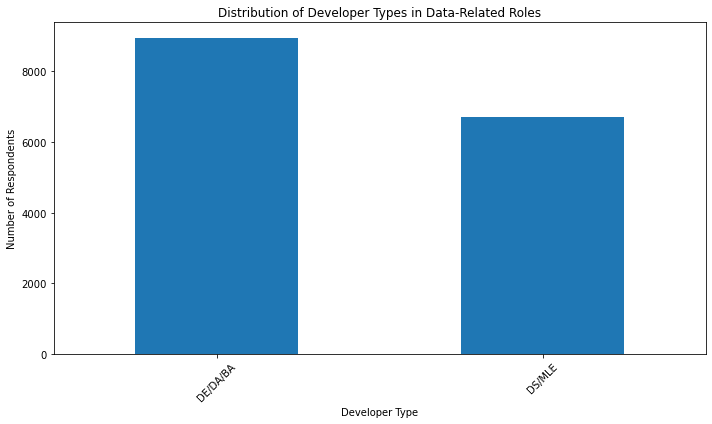

In [24]:
merged_data['DevType'] = merged_data['DevType'].apply(lambda x: 'DS/MLE' 
                                                      if 'Data scientist or machine learning specialist' in str(x) 
                                                      else ('DE/DA/BA' if 'Data or business analyst' in str(x)
                                                      else ('DE/DA/BA' if 'Engineer, data' in str(x) else x)))

data_df = merged_data[merged_data['DevType'].isin(['DS/MLE', 'DE/DA/BA'])]
dev_type_counts = data_df['DevType'].value_counts()
# Create a bar plot of Developer Type Value Counts
plt.figure(figsize=(10, 6))  # Set the size of the plot
dev_type_counts.plot(kind='bar')
plt.title("Distribution of Developer Types in Data-Related Roles")
plt.xlabel("Developer Type")
plt.ylabel("Number of Respondents")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels are not cut off
plt.show()

The proportion of DE/DA/BA practitioners is higher than that of DS/MLE, because the former does not have high requirements for statistical theory and algorithm programming ability

**Extract education level and divide education level into three groups (Bachelor, Master and Doctoral(PhD))**

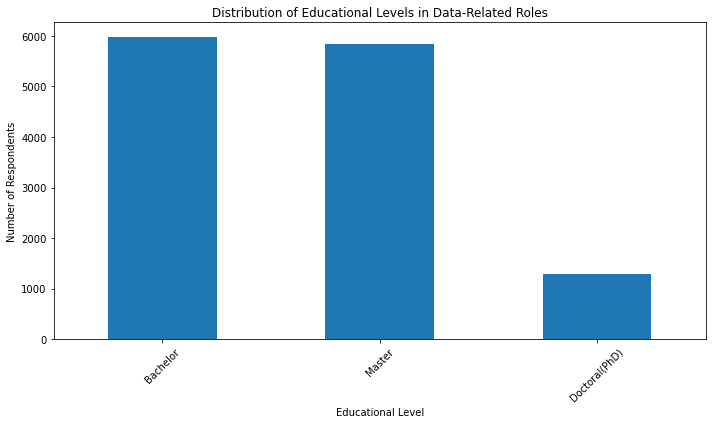

In [25]:
EdLevel_dict = {
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 'Bachelor',
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 'Master',
    'Other doctoral degree (Ph.D., Ed.D., etc.)': 'Doctoral(PhD)',
    'Professional degree (JD, MD, Ph.D, Ed.D., etc.)': 'Doctoral(PhD)'
}

data_df.loc[:, 'EdLevel'] = data_df['EdLevel'].replace(EdLevel_dict)

data_df = data_df[data_df['EdLevel'].isin(['Bachelor', 'Master', 'Doctoral(PhD)'])]
plt.figure(figsize=(10, 6))  # Set the size of the plot
data_df['EdLevel'].value_counts().plot(kind='bar')
plt.title("Distribution of Educational Levels in Data-Related Roles")
plt.xlabel("Educational Level")
plt.ylabel("Number of Respondents")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels are not cut off
plt.show()

The proportion of the number of people with bachelor's and master's is similar, much higher than that of Ph.D.

**Convert all salaries to annual salaries in USD based on average exchange rates**

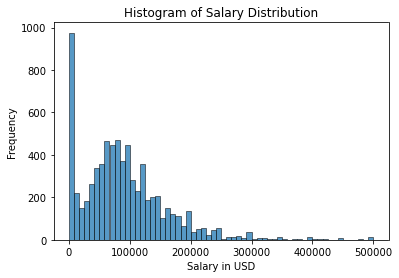

In [26]:
exchange_rates = {
    'USD': 1,
    'EUR': 1.18,
    'GBP': 1.38,
    'INR': 0.014,
    'CAD': 0.79,
    'AUD': 0.74
}

def convert_to_yearly(salary, unit):
    """
    Convert a given salary amount from different time units to yearly.

    Args:
        salary (float): The salary amount to be converted.
        unit (str): The time unit of the salary ('Yearly', 'Weekly', 'Hourly').

    Returns:
        float: The converted salary in yearly units.
    """
    if unit == 'Yearly':
        return salary
    elif unit == 'Weekly':
        return salary * 52
    elif unit == 'Hourly':
        return salary * 2080
    else:
        return salary

data_df = data_df[data_df['Currency'].isin(['USD\tUnited States dollar', 
                                            'EUR European Euro', 
                                            'GBP\tPound sterling',
                                           'INR\tIndian rupee',
                                           'CAD\tCanadian dollar',
                                           'AUD\tAustralian dollar'])]

data_df['Currency_in_USD'] = data_df['Currency'].apply(lambda currency: exchange_rates[currency.split()[0]])
data_df['Salary_USD'] = data_df['CompTotal'] * data_df['Currency_in_USD']
data_df['Salary_USD'] = data_df.apply(lambda row: convert_to_yearly(row['Salary_USD'], row['CompFreq']), axis=1)
# Salary range
data_df = data_df[(data_df['Salary_USD'] <= 500000) & (data_df['Salary_USD'] > 0)]
sns.histplot(data=data_df, x='Salary_USD')
plt.xlabel('Salary in USD')
plt.ylabel('Frequency')
plt.title('Histogram of Salary Distribution')
plt.show()

The distribution of annual salary is mostly concentrated around 10w dollars.  
There are very few people with an annual salary greater than 25w dollars.

**Transform company size categories**  

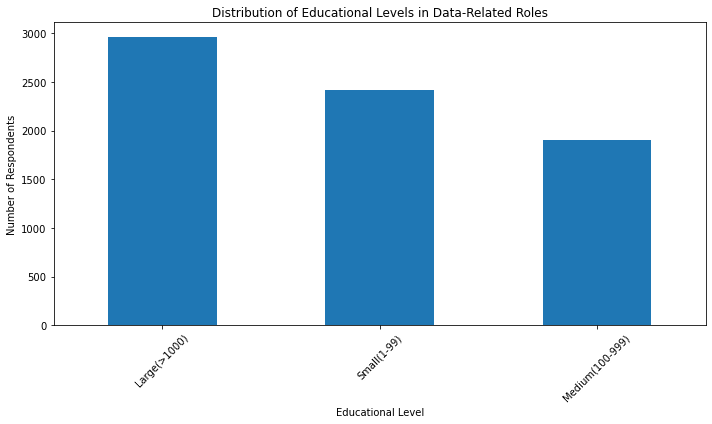

In [27]:
company_size_mapping = {
    '10,000 or more employees': 'Large(>1000)',
    '1,000 to 4,999 employees': 'Large(>1000)',
    '5,000 to 9,999 employees': 'Large(>1000)',
    '100 to 499 employees': 'Medium(100-999)',
    '500 to 999 employees': 'Medium(100-999)',
    '20 to 99 employees': 'Small(1-99)',
    '10 to 19 employees': 'Small(1-99)',
    '2 to 9 employees': 'Small(1-99)',
    'Just me - I am a freelancer, sole proprietor, etc.': 'Small(1-99)',
    'I don’t know': 'Small(1-99)'
}

data_df['CompanySize'] = data_df['OrgSize'].map(company_size_mapping)
plt.figure(figsize=(10, 6))  # Set the size of the plot
data_df['CompanySize'].value_counts().plot(kind='bar')
plt.title("Distribution of Educational Levels in Data-Related Roles")
plt.xlabel("Educational Level")
plt.ylabel("Number of Respondents")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels are not cut off
plt.show()

The proportion of large companies (>1000) is higher than that of small companies (1-99) 
than that of medium companies (100-999).

**Transform age categories**  
I divided the entire age group into 18-35 and 35+ because I think most people can complete all education degrees before the age of 35, work in entry level positions for a while, and the 35+ group is more likely to be a senior-level position

In [89]:
data_df = data_df[~data_df['Age'].isin(['Prefer not to say'])]
Age_mapping = {
    '18-24 years old': '18-35 years old',
    '25-34 years old': '18-35 years old',
    '35-44 years old': '>35 years old',
    '45-54 years old': '>35 years old',
    '55-64 years old': '>35 years old',
    '65 years or older': '>35 years old'
}

data_df['Age'] = data_df['Age'].map(Age_mapping)
data_df['Age'].value_counts()

18-35 years old    4572
>35 years old      2687
Name: Age, dtype: int64

Obviously, more people in the 18-35 age group participated in the survey

### Extract relevant columns for analysis

In [90]:
data_df = data_df[['Age', 'EdLevel', 'YearsCodePro','DevType', 'CompanySize', 'Salary_USD']]

### Handle Missing value

In [91]:
missing_percentage = (data_df.isna().sum() / len(data_df)) * 100
missing_percentage

Age             0.178768
EdLevel         0.000000
YearsCodePro    0.577558
DevType         0.000000
CompanySize     0.013751
Salary_USD      0.000000
dtype: float64

<AxesSubplot:>

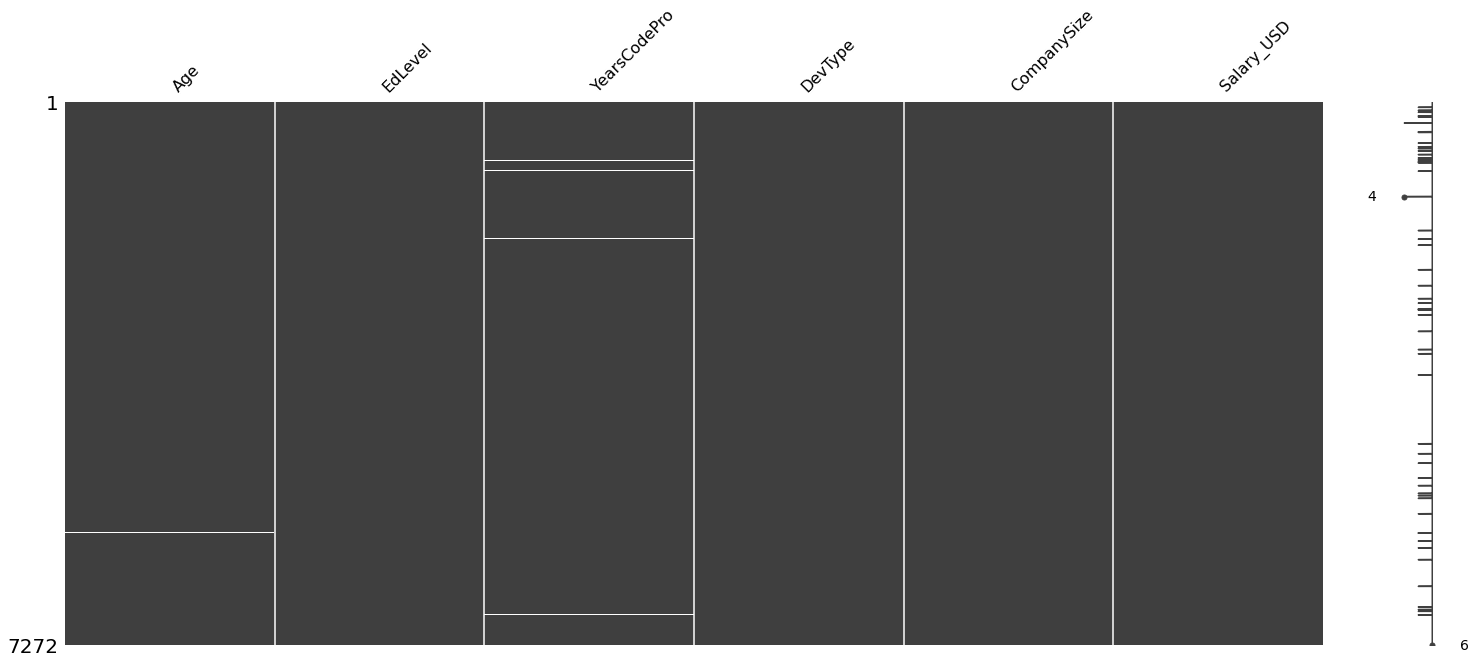

In [92]:
msno.matrix(data_df)

The proportion of missing values in each variable is very small (less than 1%), and their impact on data analysis is very small, so I choose to remove these missing values

In [31]:
data_df = data_df.dropna()
print(f"After processing, the data dimensions are {data_df.shape}, where the first value represents the number of rows and the second value represents the number of columns in the final dataset.")

After processing, the data dimensions are (7216, 15), where the first value represents the number of rows and the second value represents the number of columns in the final dataset.


### Save cleaned data

In [94]:
data_df.to_csv('/Users/tinglu/Desktop/stack-overflow-survey/Final_data.csv', index=False)